In [1]:
from datetime import datetime, date
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import KernelPCA
import calendar

from pykalman import KalmanFilter
import statsmodels.api as sm

import matplotlib.cm as cm
import math

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

from statsmodels.tsa.stattools import coint, adfuller, zivot_andrews
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from arch.unitroot import ADF as archADF
from matplotlib import gridspec

from scipy import stats

import time
import seaborn as sns
import itertools
from hurst import compute_Hc, random_walk
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.metrics.pairwise import cosine_distances, cosine_similarity, euclidean_distances
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')
from time import perf_counter

from pylr2 import regress2
from statsmodels import regression, stats
from sklearn.cluster import OPTICS
from IPython.display import clear_output

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def JohSpr(pair):
    pair = list(pair)
    var = VAR(clean_prices[list(pair)][fP1:fP2])
    x = var.select_order()
    jres = coint_johansen(clean_prices[list(pair)][fP1:fP2],det_order = 0, k_ar_diff=max(0,x.selected_orders['aic']-1))
    spr = (clean_prices[pair][fP1:fP2]*jres.evec[:,0]).sum(axis=1)
    
    meanSpr = spr.mean()
    stdSpr = spr.std()
    normSpr = ((clean_prices[pair][fP1:tP2]*jres.evec[:,0]).sum(axis=1)-meanSpr)/stdSpr
    return normSpr, jres.evec[:,0], stdSpr

def pos_func(nSpr, entries, weights, stoploss=np.nan, block=False, push=True):
    posit = pd.Series(np.nan, index=nSpr[tP1:tP2].index, name='Pos')
    posit.iloc[0] = 0
    posit[nSpr*nSpr.shift(1) < 0] = 0
    for i in np.arange(len(entries)):
        posit[(nSpr+entries[i])*(nSpr.shift(1)+entries[i])< 0] = weights[i]
        posit[(nSpr-entries[i])*(nSpr.shift(1)-entries[i])< 0] = -weights[i]
    if not np.isnan(stoploss):
        posit[(nSpr+float(stoploss))*(nSpr.shift(1)+float(stoploss))< 0] = 0
        posit[(nSpr-float(stoploss))*(nSpr.shift(1)-float(stoploss))< 0] = 0
    else:
        block=False
    posit.ffill(inplace=True)
    
    if len(entries) > 1:
        for i in range(1,len(posit)):
            if abs(posit).values[i]>abs(posit).values[i-1] or abs(posit).values[i]==0 or \
            posit.values[i]*posit.values[i-1]<0:
                posit.values[i]=posit.values[i].copy()
            else:
                posit.values[i]=posit.values[i-1].copy()
    if block:
        if not nSpr[(nSpr>float(stoploss)) | (nSpr<-float(stoploss))].empty:
            posit[nSpr[(nSpr>float(stoploss)) | (nSpr<-float(stoploss))].index[0]:] = 0
    if push:
        posit=posit.shift(1)
        posit.iloc[0]=0
    return posit

def equity_curve(positions, df, weiV, initial_cash=100, leverage=2,shorting_cost=0.01,commission=0.0008,market_impact=0.002):
    trades=positions.diff()
    trades.iloc[0]=positions[0]-0
    cash=pd.Series(data=np.nan,index=positions.index,name='Cash')
    portfolio=pd.Series(data=np.nan,index=positions.index,name='Portfolio')
    shares=pd.Series(data=np.nan,index=positions.index,name='Shares')
    transaction_costs=pd.Series(data=np.nan,index=positions.index,name='Tc')
    
    portfolio.iloc[0]=initial_cash
    shares.iloc[0]=leverage*portfolio.iloc[0]/abs(df*weiV).sum(axis=1)[0]
    cash.iloc[0]=portfolio.iloc[0]-(shares[0]*df.iloc[0]*weiV*trades[0]).sum()
    transaction_costs.iloc[0]=abs(shares[0]*weiV*df.iloc[0]*trades[0]).sum()*(commission+market_impact)+(shares[0]*positions[0]*df.iloc[0]*weiV).combine(0, min).sum()*(-shorting_cost/252)

    for i in range(1,len(cash)):
        if ~(((positions[i]>0) & (trades[i]>0)) | ((positions[i]<0) & (trades[i]<0))):
            shares.iloc[i]=shares.iloc[i-1]
        else:
            shares.iloc[i]=leverage*portfolio.iloc[i-1]/abs(df*weiV).sum(axis=1)[i]
        transaction_costs.iloc[i]=abs(shares[i]*weiV*df.iloc[i]*trades[i]).sum()*(commission+market_impact)+(shares[i]*positions[i]*df.iloc[i]*weiV).combine(0, min).sum()*(-shorting_cost/252)
        cash.iloc[i]=cash.iloc[i-1]-(shares[i]*df.iloc[i]*weiV*trades[i]).sum()-transaction_costs.iloc[i]
        portfolio.iloc[i]=cash.iloc[i]+(shares[i]*positions[i]*df.iloc[i]*weiV).sum()
        
    return portfolio

In [46]:
###Parameters
stock_index = 'SNP'          #SNP, NIKKEI, BOVESPA
formation_year = 2012        #2010-2020 - when we take the components of the index
brkdwn = 'Industry'          #Sector/Industry
formation_period = 12        #in months, integers only
trading_period = 6          #in months, integers only

#Getting data
comp_stats=pd.read_csv("{}_comp_stats.csv".format(stock_index),index_col=0)
price_data=pd.read_csv("{}_prices2005-2021.csv".format(stock_index),index_col=0)
tickers=pd.read_csv("{}_tickers_2010-2020.csv".format(stock_index),index_col=0)

In [47]:
#Defining formation and trading periods
def create_dates(formation_date):
    trading_start=str(pd.Timestamp(formation_date).date())
    formation_start =str((pd.Timestamp(formation_date)-pd.DateOffset(months=formation_period)).date())
    endD=str((pd.Timestamp(formation_date)+pd.DateOffset(months=trading_period)).date())

    formation_end = str((pd.Timestamp(trading_start)-pd.DateOffset(days=1)).date())
    trading_end = str((pd.Timestamp(endD)-pd.DateOffset(days=1)).date())
    return formation_start, formation_end, trading_start, trading_end

formation_date = '{}-01-01'.format(formation_year)
formation_year = int(formation_date[0:4])
fP1, fP2, tP1, tP2 = create_dates(formation_date)

In [48]:
def clean_data(fP1, tP2, formation_year, stock_index):
    #Only include tickers that are in the stock index for the year and we have data for it
    valid_tickers=(set(price_data[fP1:tP2].columns)) & (set(tickers.loc[formation_year][stock_index]))

    #Drop ticker that miss >20% of their price series, forward fill the rest,
    #then drop the tickers that still has missing values,
    #those can only have it at the start of their price series, would cause problems later in testing
    clean_prices=price_data[fP1:tP2][valid_tickers]
    clean_prices=clean_prices.dropna(axis=1,thresh=round(clean_prices.shape[0]*0.8))
    clean_prices=clean_prices.fillna(method="ffill")
    if pd.isnull(clean_prices.iloc[0]).all():
        clean_prices=clean_prices.drop(clean_prices.index[0], axis=0)
    clean_prices=clean_prices.dropna(axis=1)
    
    return clean_prices

clean_prices = clean_data(fP1, tP2, formation_year, stock_index)

In [49]:
def get_returns(data, start, end, normalize = True, winsorize = False):
    returns = data[start:end].pct_change()
    returns.dropna(inplace = True)

    if normalize:
        returns = (returns - returns.mean())/returns.std()
        
    if winsorize:
        for ticker in returns:
            qmax = np.percentile(returns[ticker], 99)
            qmin = np.percentile(returns[ticker], 1)
            returns.loc[returns[ticker]>qmax,ticker] = qmax
            returns.loc[returns[ticker]<qmin,ticker] = qmin
            
    return returns
            
returns = get_returns(clean_prices, fP1, fP2)

In [50]:
def make_clusters(rets, no_pc, min_samp):
    pca = PCA(n_components=no_pc, random_state = 1)
    pca.fit(rets)
    components = pca.components_.T
    clustering = OPTICS(min_samples = min_samp, xi = 0.01).fit(components)
    
    return clustering

clustering = make_clusters(returns, 3, 5)

In [51]:
clustered_tickers = pd.Series(index = returns.columns,data = clustering.labels_.flatten())

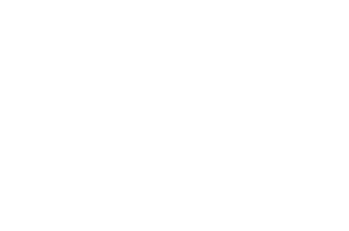

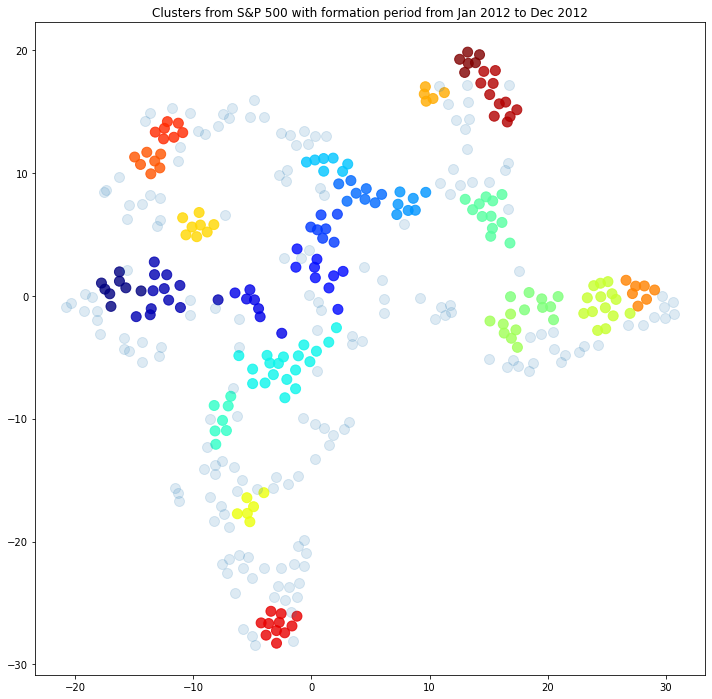

In [60]:
pca = PCA(n_components=3, random_state = 1)
pca.fit(returns)
components = pca.components_.T

X_tsne = TSNE(learning_rate=100, perplexity=25, random_state=1337).fit_transform(components)
cmap = plt.get_cmap('jet')


plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')
plt.figure(figsize=(12,12))
plt.scatter(
    X_tsne[(clustering.labels_!=-1), 0],
    X_tsne[(clustering.labels_!=-1), 1],
    s=100,
    alpha=0.80,
    c=clustering.labels_[clustering.labels_!=-1],
    cmap=cmap
)

plt.scatter(
    X_tsne[(clustered_tickers==-1).values, 0],
    X_tsne[(clustered_tickers==-1).values, 1],
    s=100,
    alpha=0.15);

plt.title('Clusters from S&P 500 with formation period from Jan 2012 to Dec 2012');

In [63]:
clustered_tickers.max()+1

23

In [12]:
def get_stationary_tickers(clean_prices):
    stat_tics = []
    for i in clean_prices:
        if archADF(clean_prices[fP1:fP2][i]).pvalue < 0.05:
            stat_tics.append(i)
    return stat_tics

stat_tics = get_stationary_tickers(clean_prices)
#Remove stationary price series from the dataset
clean_prices=clean_prices.drop(stat_tics, axis=1)

In [13]:
clustered_tickers.drop(labels = stat_tics, inplace = True)

In [14]:
brkdwn_list = []
for i in range(clustered_tickers.max()):
    brkdwn_list.append(list(clustered_tickers[clustered_tickers == i].index))

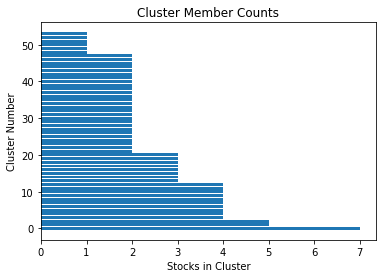

In [15]:
plt.barh(   range(len(clustered_tickers[clustered_tickers != -1].value_counts())),
            clustered_tickers[clustered_tickers != -1].value_counts())
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');

,Name,Sector,Industry,Summary
5541.T,"Pacific Metals Co., Ltd.",Basic Materials,Steel,"Pacific Metals Co., Ltd. produces and sells fe..."
7731.T,Nikon Corporation,Consumer Cyclical,Leisure,Nikon Corporation manufactures and sells optic...


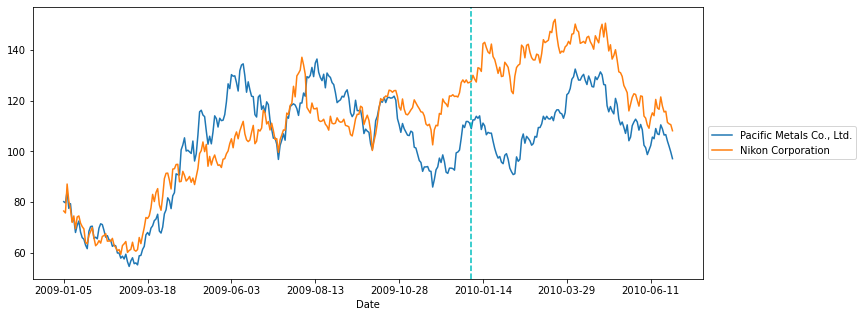

In [16]:
cluster_no = 7

(100*clean_prices[brkdwn_list[cluster_no]][fP1:tP2]/clean_prices[brkdwn_list[cluster_no]][fP1:fP2].mean()).plot(figsize=(12,5));
plt.legend(comp_stats.loc[brkdwn_list[cluster_no]].Name, loc='center left', bbox_to_anchor=(1, 0.5))
plt.axvline(clean_prices[fP1:fP2].shape[0], color='c', linestyle='--');
display(comp_stats.loc[brkdwn_list[cluster_no]].sort_values(by = 'Sector'))

In [17]:
def get_coint_pairs_johansen(brkdwn_list):
    total = 0
    noPosP = 0
    for i in range(len(brkdwn_list)):
        noPosP += (len(list(itertools.combinations(brkdwn_list[i],2))))

    allPosPairs = pd.DataFrame(columns=['Pair','Joh1sig','Joh2sig','autocorr','LS'],index=np.arange(noPosP))

    for i in range(len(brkdwn_list)):
        for pair in list(itertools.combinations(brkdwn_list[i],2)):
            allPosPairs.iloc[total,0] = pair

            var = VAR(clean_prices[list(pair)][fP1:fP2])
            x = var.select_order()
            model_fitted = var.fit(x.selected_orders['aic'])
            allPosPairs.iloc[total,3] = (acorr_ljungbox(model_fitted.resid.iloc[:,1],lags=x.selected_orders['aic'])[1]<0.05).sum()
            +(acorr_ljungbox(model_fitted.resid.iloc[:,0],lags=x.selected_orders['aic'])[1]<0.05).sum()
            jres = coint_johansen(clean_prices[list(pair)][fP1:fP2],det_order = 0, k_ar_diff = max(0, x.selected_orders['aic']-1))

            allPosPairs.iloc[total,1] = (jres.cvt[0]<jres.lr1[0]).sum()
            allPosPairs.iloc[total,2] = (jres.cvt[1]<jres.lr1[1]).sum()
            if jres.evec[0,0] * jres.evec[1,0] < 0:
                allPosPairs.iloc[total,4] = 1
            else:
                allPosPairs.iloc[total,4] = 0
            total += 1
            #if total % 100 == 0:
            #    clear_output(wait=True)
            #    print(total, '/', noPosP)
    return allPosPairs
allPosPairs = get_coint_pairs_johansen(brkdwn_list)
pairsJ = list(allPosPairs.query('Joh1sig>=2 & Joh2sig<2 & autocorr==0 & LS==1').Pair)
print(allPosPairs.shape[0])
print(len(pairsJ))

152
9


In [18]:
pair_NAVs = pd.DataFrame()
slHit = 0
avgTr = []
for c, pair in enumerate(pairsJ):
    nSpr, weiV, stdSpr = JohSpr(list(pair))
    oosNSpr = nSpr[tP1:tP2]
    positions = pos_func(oosNSpr,entries=np.array([2]),weights=np.array([1.0]),block=True,stoploss=5)
    port = equity_curve(positions, clean_prices[list(pair)][tP1:tP2], weiV,shorting_cost=0.0,commission=0.0,market_impact=0.0)
    pair_NAVs = pd.concat([pair_NAVs, port], axis=1)
    #if c%10==0:
    #    clear_output(wait=True)
    #    print(c,'/',len(pairsJ))
    
    if any(abs(oosNSpr)>5):
        slHit += 1
        avgTr.append((abs(positions.diff()).sum()/2)-1)
    else:
        avgTr.append(abs(positions.diff()).sum()/2)
    
    
strat_values = pair_NAVs.mean(axis=1)

MDD=pd.Series(np.nan,index=strat_values.index)
MDD[0]=1
for i in range(1, len(MDD)):
    MDD[i]=min(1,MDD[i-1]*(1+strat_values.pct_change()[i]))

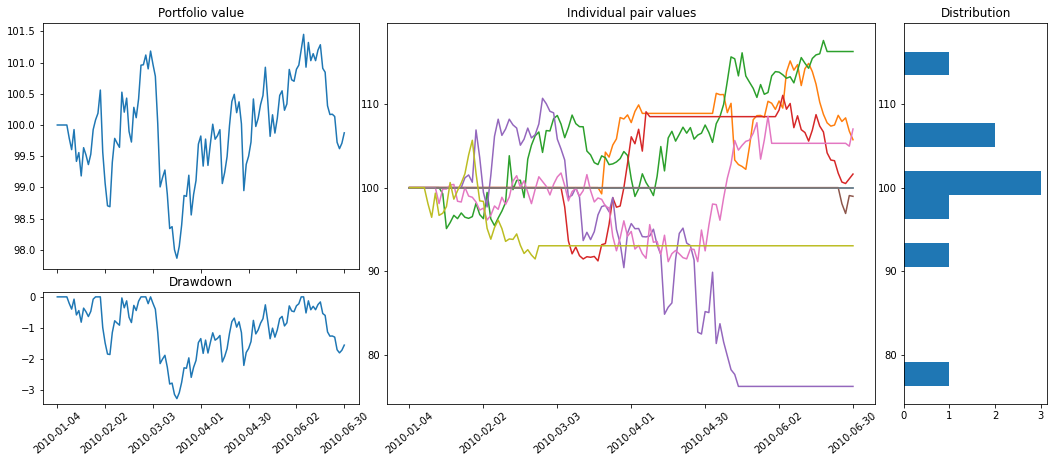

In [19]:
def plot_result():
    fig = plt.figure(figsize=(18,7));
    gs = plt.GridSpec(3,6);

    axis1 = plt.subplot(gs[0:2,0:2]);
    strat_values.plot();
    plt.title('Portfolio value');
    axis2 = plt.subplot(gs[2,0:2],sharex=axis1);
    ((MDD-1)*100).plot();
    plt.title('Drawdown');
    plt.xticks(rotation=40);
    axis3 = plt.subplot(gs[0:3,2:5]);
    for i in range(0, len(pairsJ)):
        pair_NAVs.iloc[:,i].plot(linestyle='-',legend=False);
    plt.title('Individual pair values');
    plt.xticks(rotation=40);
    axis4 = plt.subplot(gs[0:3,5],sharey=axis3);
    n = math.ceil((pair_NAVs.iloc[-1].max() - pair_NAVs.iloc[-1].min())/3);
    plt.hist(pair_NAVs.iloc[-1], bins = max(1,n), orientation='horizontal');
    plt.title('Distribution');
    plt.show();
    
plot_result()

In [294]:
###Parameters
stock_index = 'NIKKEI'          #SNP, NIKKEI, BOVESPA
formation_period = 12        #in months, integers only
trading_period = 6          #in months, integers only

#Getting data
comp_stats=pd.read_csv("{}_comp_stats.csv".format(stock_index),index_col=0)
price_data=pd.read_csv("{}_prices2005-2021.csv".format(stock_index),index_col=0)
tickers=pd.read_csv("{}_tickers_2010-2020.csv".format(stock_index),index_col=0)

Date: 2010-01-01
Final value: 98.39286282953837
Pairs: 12 / 167


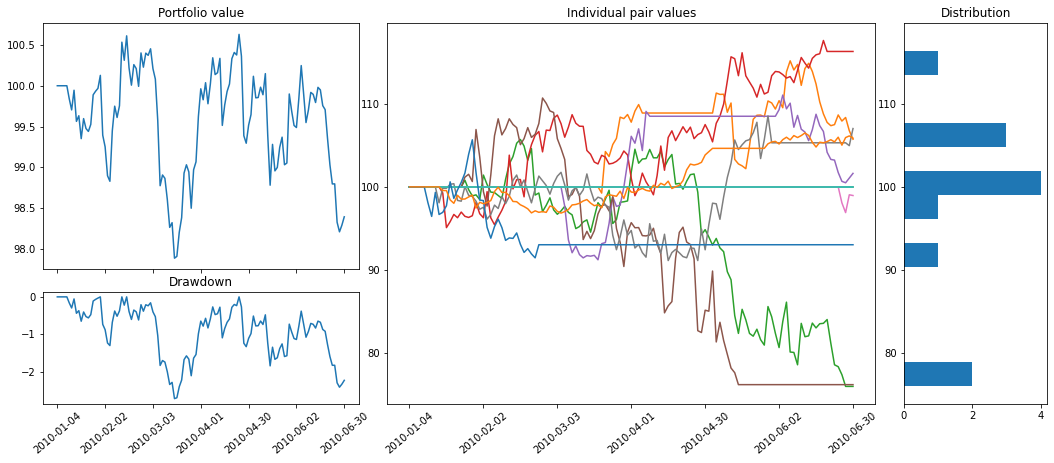

Date: 2010-07-01
Final value: 101.75378658938713
Pairs: 4 / 166


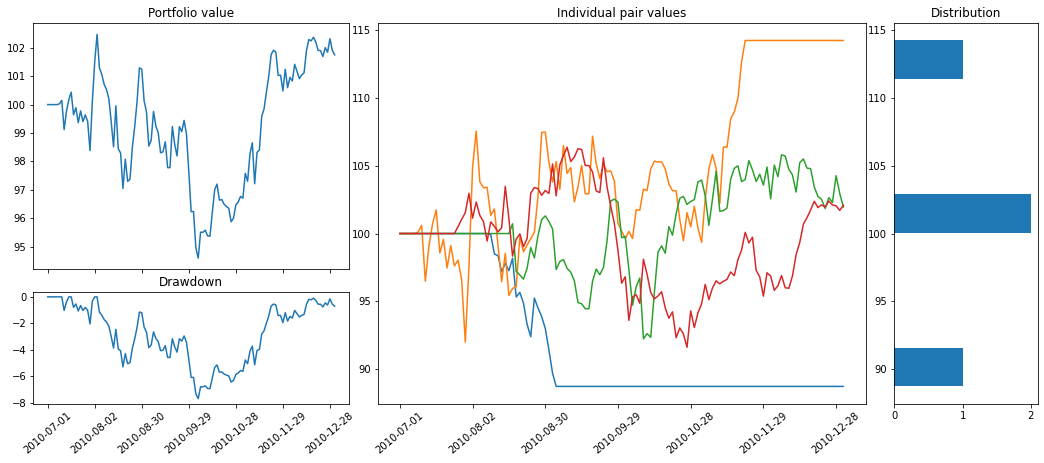

Date: 2011-01-01
Final value: 111.1635918193755
Pairs: 6 / 179


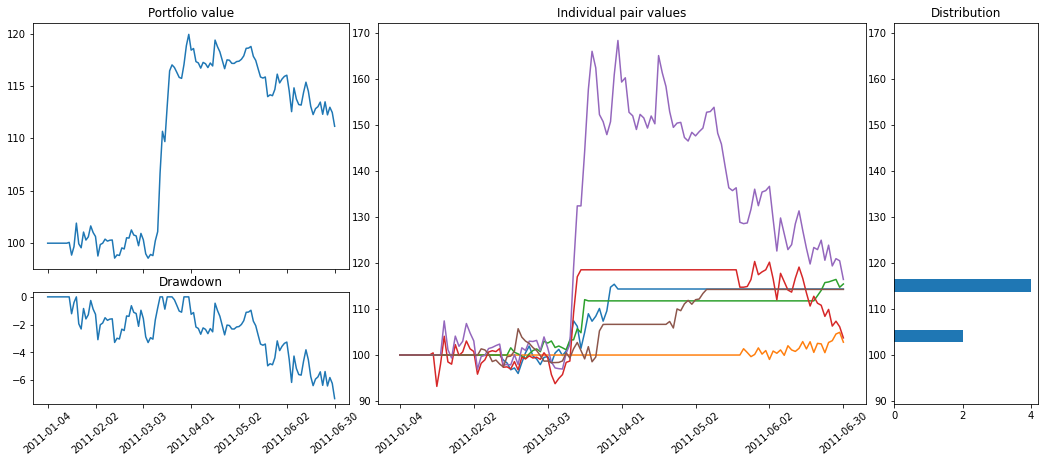

Date: 2011-07-01
Final value: 91.68911808230686
Pairs: 15 / 152


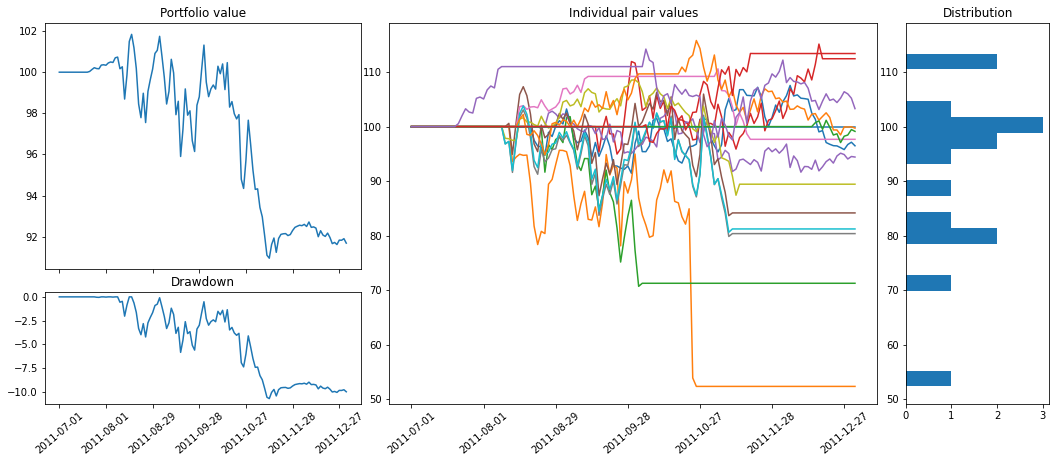

Date: 2012-01-01
Final value: 100.20208115140612
Pairs: 10 / 204


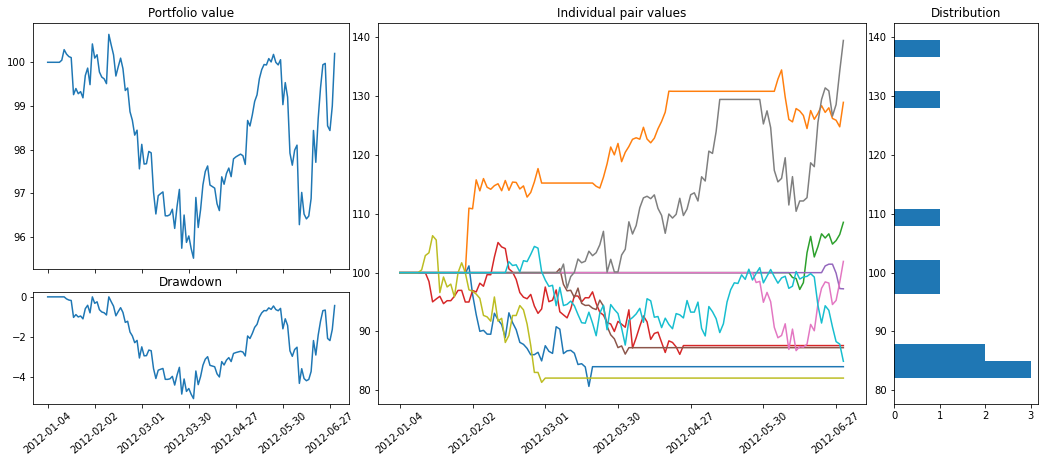

Date: 2012-07-01
Final value: 95.44063379429306
Pairs: 8 / 159


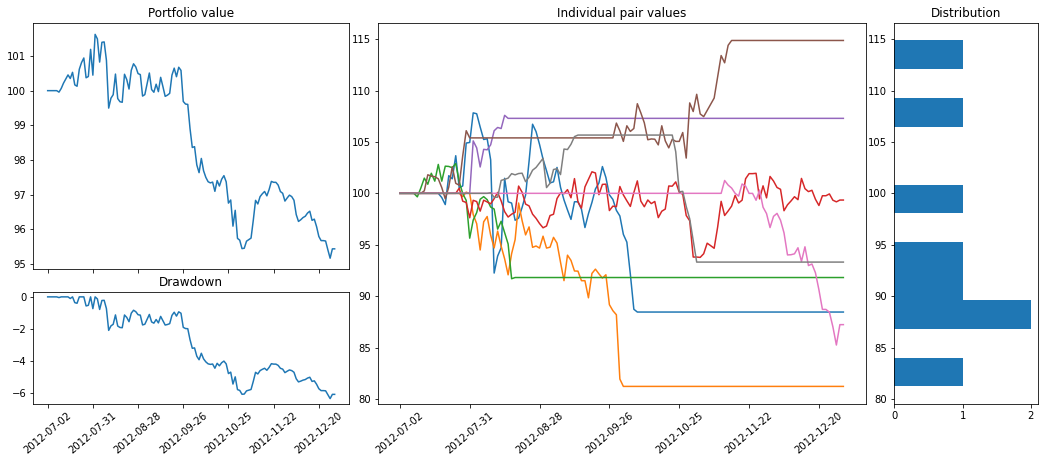

Date: 2013-01-01
Final value: 97.03545950209592
Pairs: 19 / 171


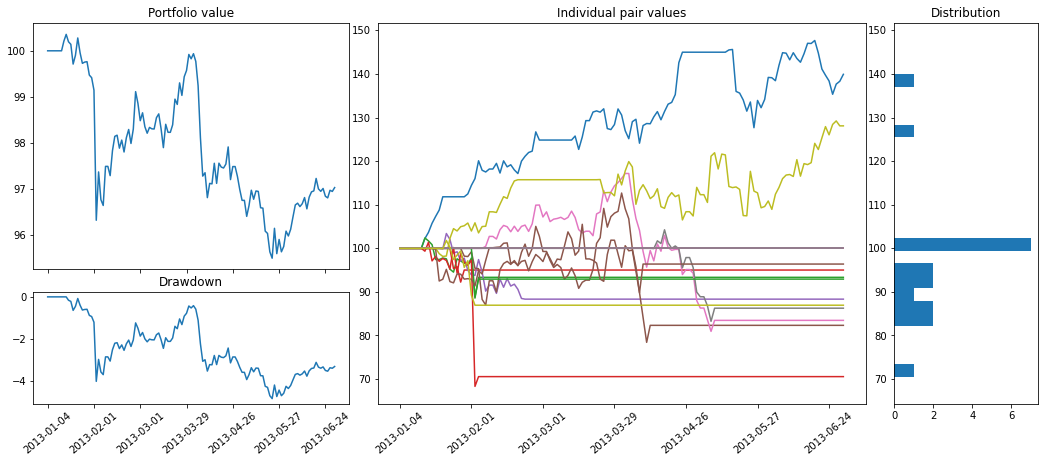

Date: 2013-07-01
Final value: 101.49408469453279
Pairs: 23 / 188


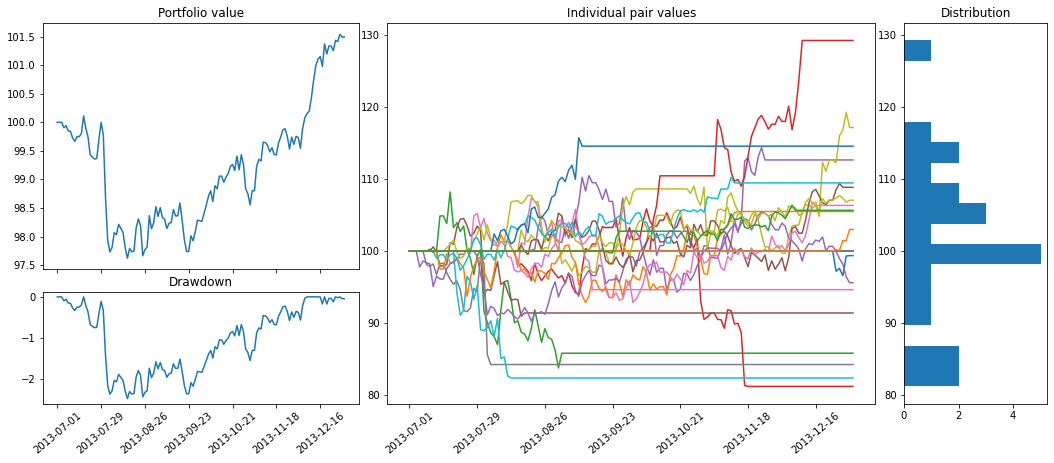

Date: 2014-01-01
Final value: 108.79241533152144
Pairs: 3 / 192


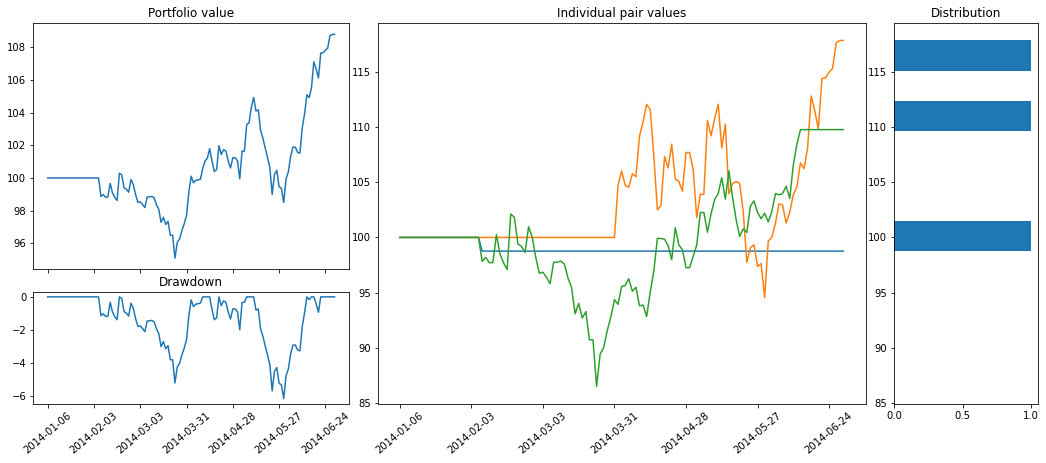

Date: 2014-07-01
Final value: 103.61558789288985
Pairs: 9 / 224


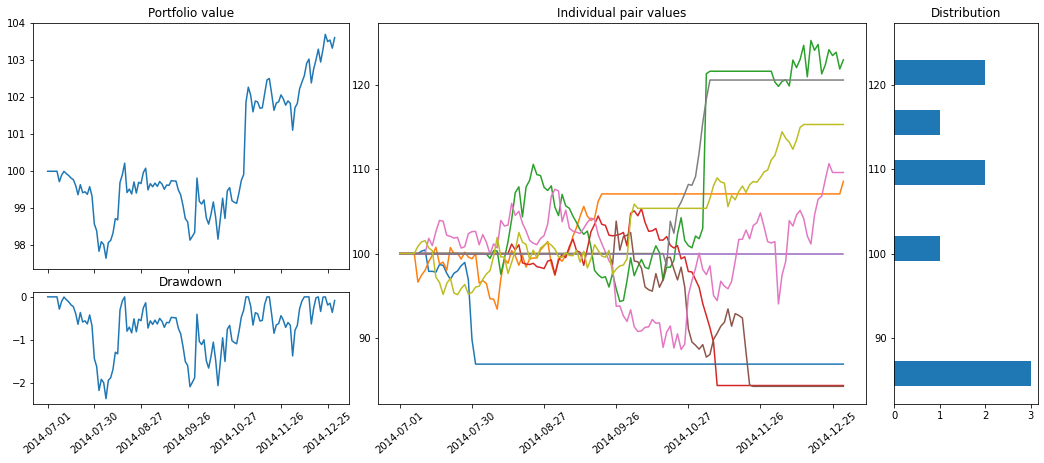

Date: 2015-01-01
Final value: 100.82375312466965
Pairs: 8 / 233


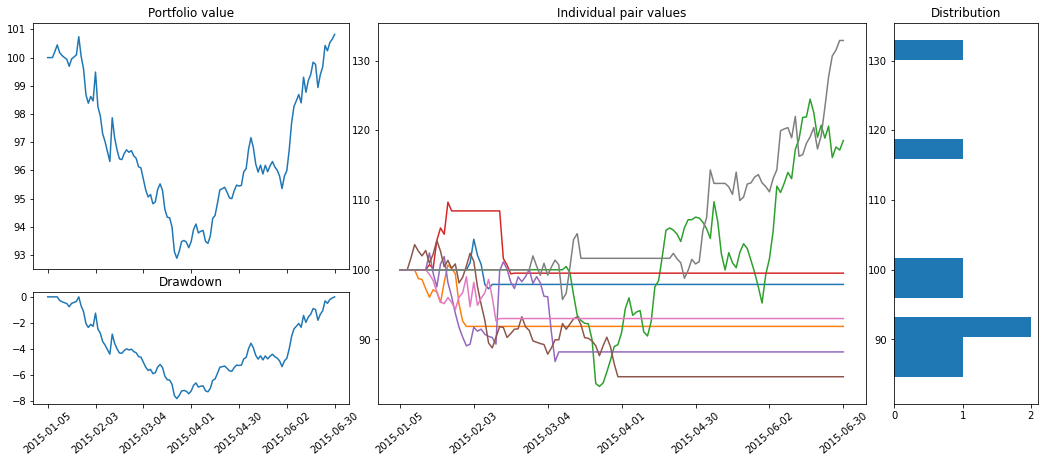

Date: 2015-07-01
Final value: 97.71135487885812
Pairs: 11 / 150


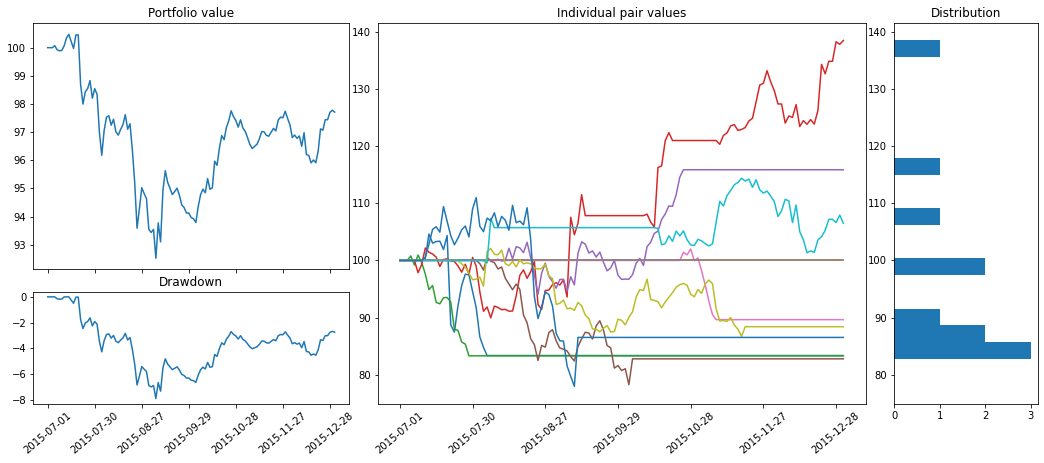

Date: 2016-01-01
Final value: 89.68316615964748
Pairs: 8 / 176


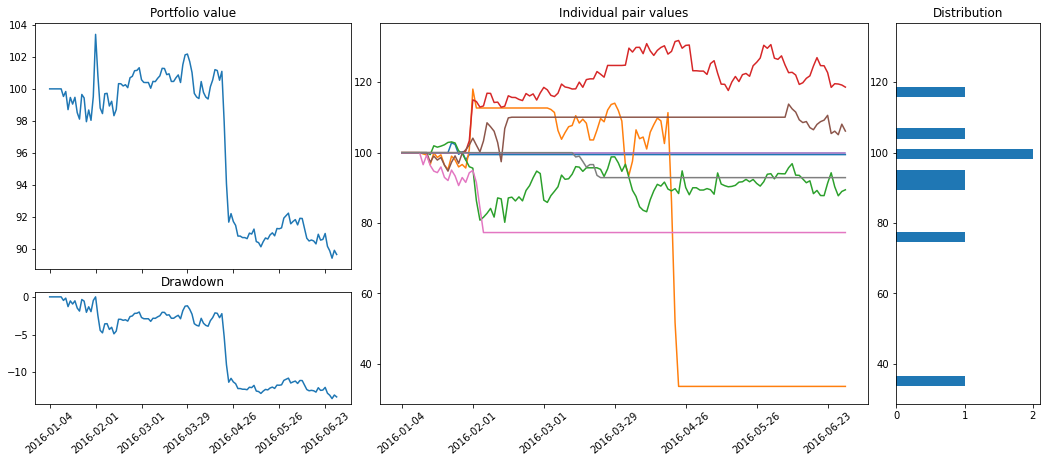

Date: 2016-07-01
Final value: 110.46268953945791
Pairs: 10 / 195


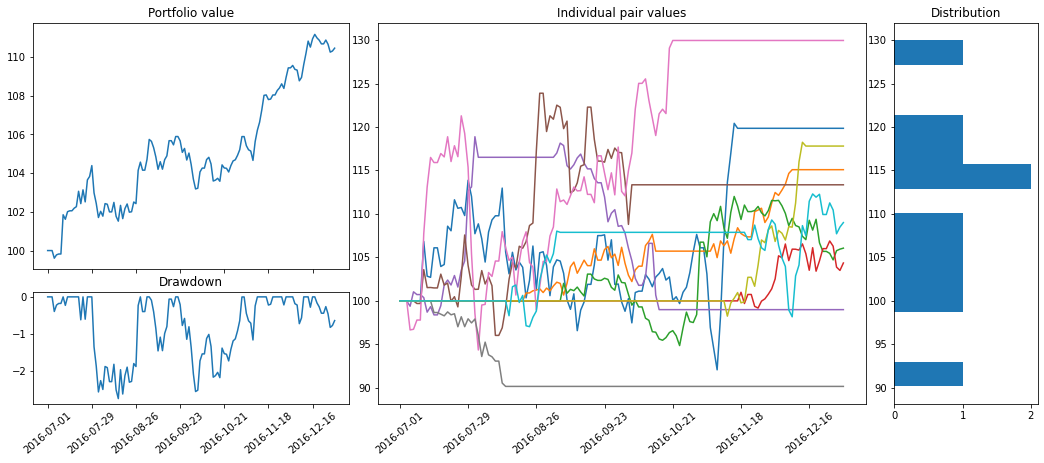

Date: 2017-01-01
Final value: 103.02794639411695
Pairs: 13 / 155


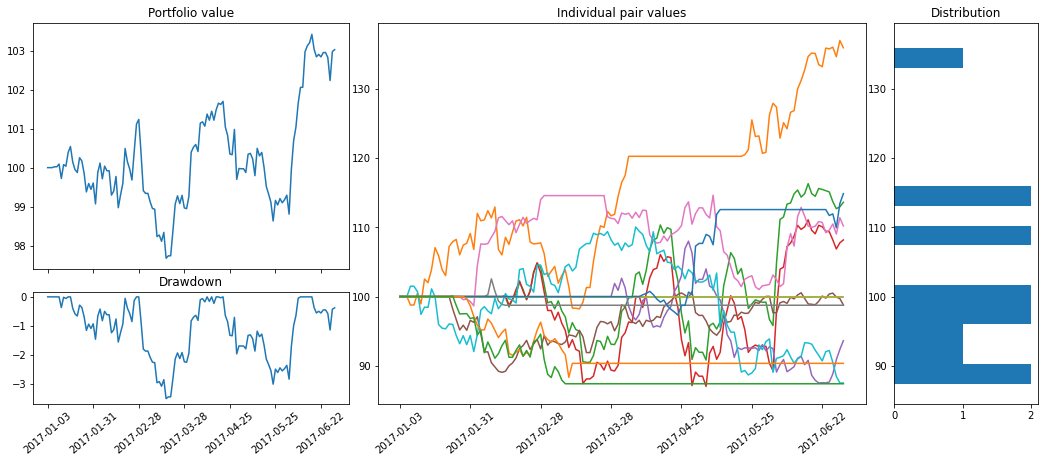

Date: 2017-07-01
Final value: 94.59617804875593
Pairs: 3 / 153


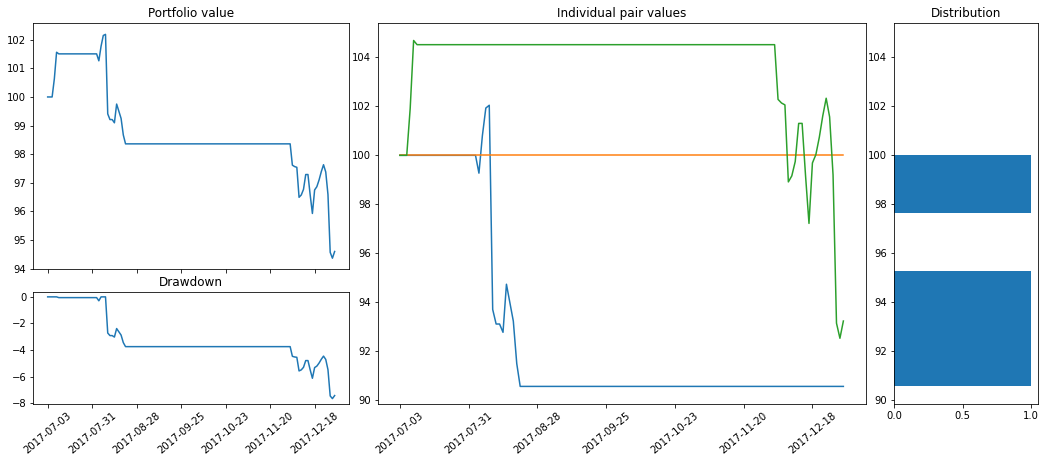

Date: 2018-01-01
Final value: 100.74142474471641
Pairs: 6 / 181


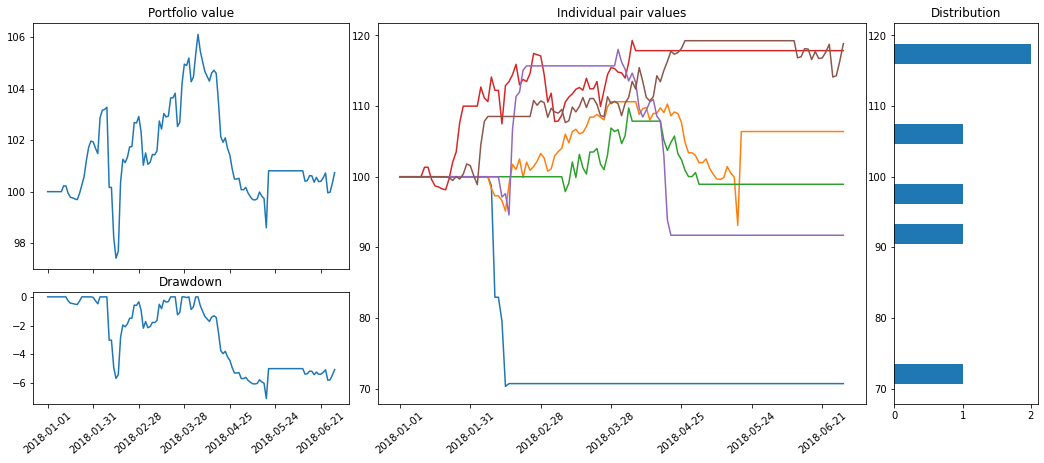

Date: 2018-07-01
Final value: 108.22394458407459
Pairs: 5 / 180


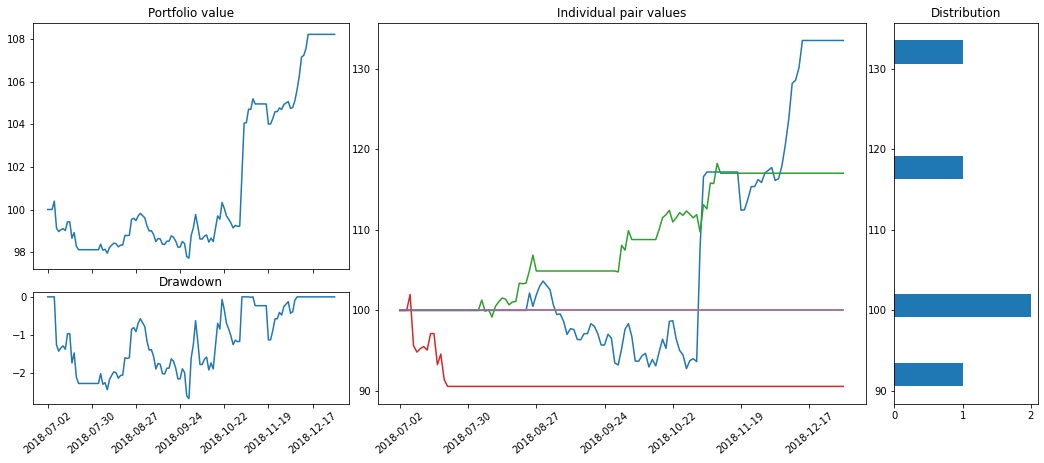

Date: 2019-01-01
Final value: 92.30422274583239
Pairs: 2 / 210


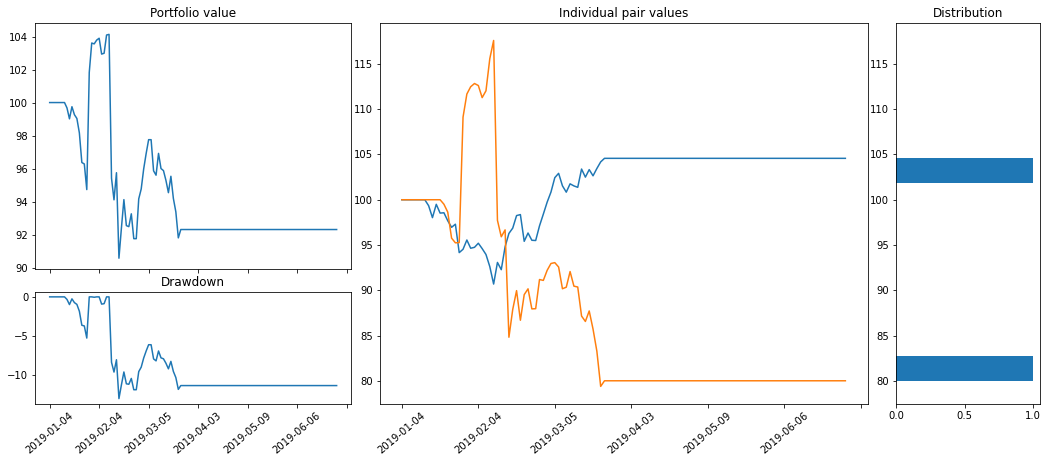

Date: 2019-07-01
Final value: 103.2978958658154
Pairs: 12 / 228


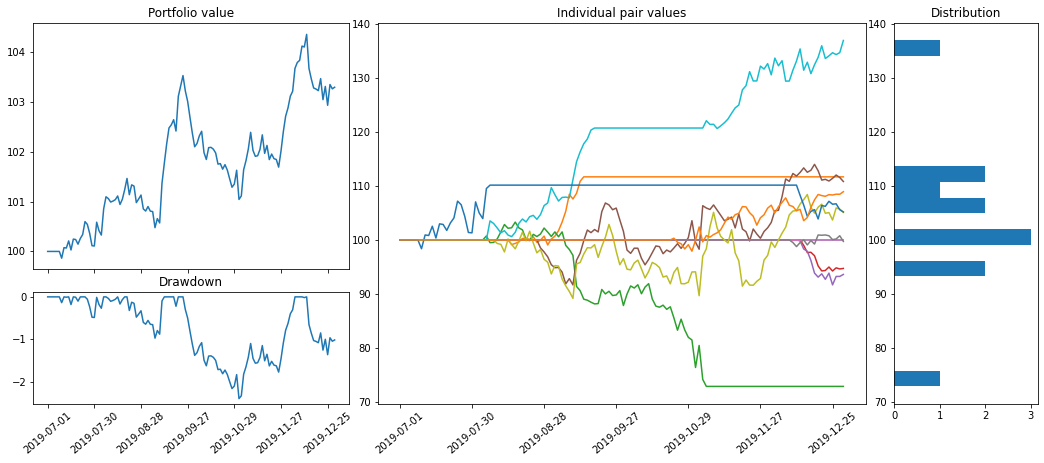

Date: 2020-01-01
Final value: 93.53022583232045
Pairs: 12 / 193


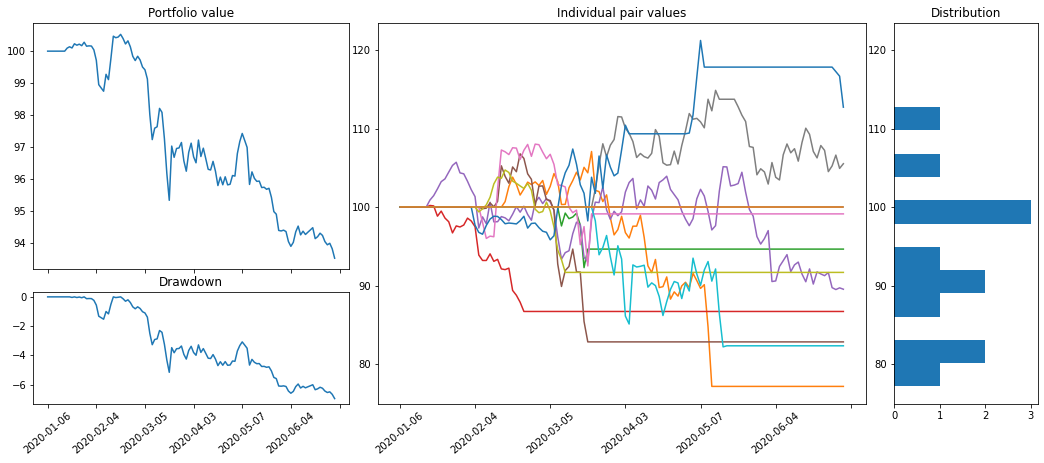

Date: 2020-07-01
Final value: 97.33487842416199
Pairs: 13 / 185


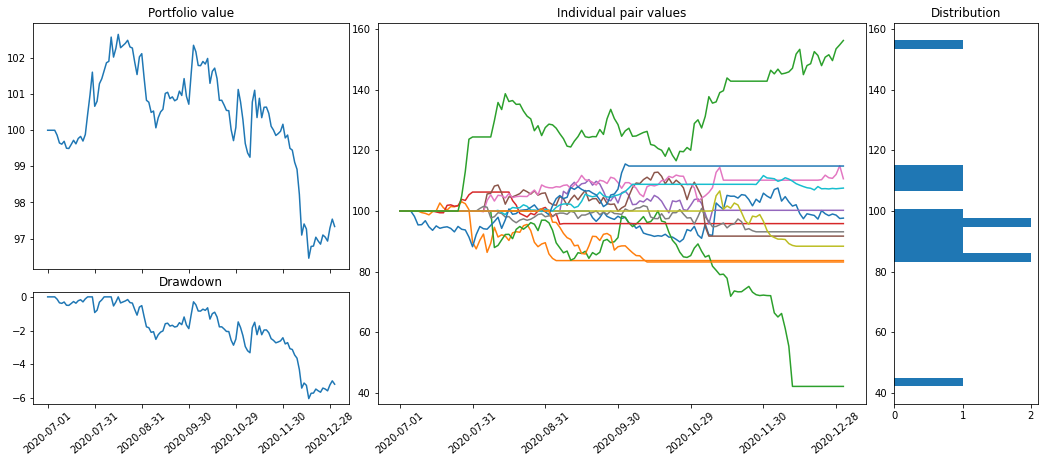



366.8568290000003


In [295]:
t0 = time.perf_counter()

strat_returns=pd.DataFrame()
allConsDates = ['2010-01-01']
i = 1
while int(allConsDates[-1][0:4])<2021:
    allConsDates.append(str((pd.Timestamp('2010-01-01')+pd.DateOffset(months=trading_period*i)).date()))
    i += 1
allConsDates.pop()
pairsData = pd.DataFrame(0,columns=['All','Selected','StoplossHit','Profitable','AvgTrade'],index=allConsDates)

for formation_date in allConsDates:
    formation_year = int(formation_date[0:4])
    fP1, fP2, tP1, tP2 = create_dates(formation_date)
    
    clean_prices = clean_data(fP1, tP2, formation_year, stock_index)
    stat_tics = get_stationary_tickers(clean_prices)
    returns = get_returns(clean_prices, fP1, fP2)
    clustering = make_clusters(returns, no_pc = 3, min_samp = 2)
    clustered_tickers = pd.Series(index = returns.columns,data = clustering.labels_.flatten())
    
    
    #clean_prices=clean_prices.drop(stat_tics, axis=1)
    #clustered_tickers.drop(labels = stat_tics, inplace = True)
    brkdwn_list = []
    for i in range(clustered_tickers.max()):
        brkdwn_list.append(list(clustered_tickers[clustered_tickers == i].index))
    
    allPosPairs = get_coint_pairs_johansen(brkdwn_list)
    pairsJ = list(allPosPairs.query('Joh1sig>=2 & Joh2sig<2 & autocorr==0 & LS==1').Pair)
    noPosP = allPosPairs.shape[0]
    
    pair_NAVs = pd.DataFrame()
    slHit = 0
    avgTr = []
    for c, pair in enumerate(pairsJ):
        nSpr, weiV, stdSpr = JohSpr(list(pair))
        oosNSpr = nSpr[tP1:tP2]
        positions = pos_func(oosNSpr,entries=np.array([2]),weights=np.array([1.0]),block=True,stoploss=5)
        port = equity_curve(positions, clean_prices[list(pair)][tP1:tP2], weiV,shorting_cost=0.0,commission=0.0,market_impact=0.0)
        pair_NAVs = pd.concat([pair_NAVs, port], axis=1)
        #if c%10==0:
        #    clear_output(wait=True)
        #    print(c,'/',len(pairsJ))

        if any(abs(oosNSpr)>5):
            slHit += 1
            avgTr.append((abs(positions.diff()).sum()/2)-1)
        else:
            avgTr.append(abs(positions.diff()).sum()/2)
    pairsData.loc[formation_date,'StoplossHit'] = slHit
    pairsData.loc[formation_date,'All'] = noPosP
    pairsData.loc[formation_date,'Selected'] = len(pairsJ)
    pairsData.loc[formation_date,'Profitable'] = (pair_NAVs.iloc[-1]>100).sum()
    pairsData.loc[formation_date,'AvgTrade'] = sum(avgTr)/len(avgTr)

    
    strat_values = pair_NAVs.mean(axis=1)
    if strat_values.empty:
        strat_values=pd.Series(100,index=clean_prices[tP1:tP2].index)
        
    MDD=pd.Series(np.nan,index=strat_values.index)
    MDD[0]=1
    for i in range(1, len(MDD)):
        MDD[i]=min(1,MDD[i-1]*(1+strat_values.pct_change()[i]))
        
    strat_returns=pd.concat([strat_returns,strat_values.pct_change()],axis=0)
    
    print('Date:',formation_date)
    print('Final value:',strat_values[-1])
    print('Pairs:',len(pairsJ),'/',noPosP)

    plot_result();
    
t1 = time.perf_counter()
print('\n');print(t1-t0)

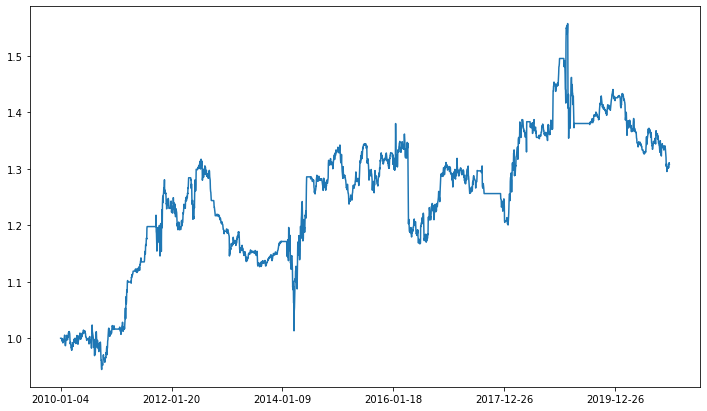

In [275]:
strat_eq=(strat_returns.fillna(0)+1).cumprod()
strat_eq.plot(figsize=(12,7),legend=False);